In [1]:
!pip install -U sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, 1.)

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt_for_submission.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt_for_submission.csv')
print(customers.shape)
customers.head()

(47128, 5)


,customer_id,FN,Active,age,customer_id_idx
0,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,0
1,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0.0,0.0,0.29,1
2,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0.0,0.0,0.23,2
3,000fb6e772c5d0023892065e659963da90b1866035558e...,1.0,1.0,0.42,3
4,0010e8eb18f131e724d6997909af0808adbba057529edb...,1.0,1.0,0.25,4


### Create article EmbeddingBag

In [10]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [12]:
embeddings = model.encode(article_descriptions)

In [13]:
embeddings = torch.tensor(embeddings)

In [14]:
embeddings.shape

torch.Size([40538, 384])

In [15]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [16]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+384+3, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [17]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [18]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(47128, 384)
  (fc_1): Linear(in_features=771, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [19]:
BATCH_SIZE = 1024

In [20]:
total_training_examples = pd.read_csv('data/final_train_set_for_submission.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

47.0

In [21]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)  # 0.0001
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [22]:
MAX_EPOCHS = 75

training_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    # scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)        
        
    fashion_rec_v3.train()

100%|██████████| 47/47.0 [00:14<00:00,  3.24it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.14it/s]


Training loss: 26.700560492543246


100%|██████████| 47/47.0 [00:14<00:00,  3.34it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.15it/s]


Training loss: 26.15029454979988


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.15it/s]


Training loss: 26.060017611818147


100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 25.7555110570713


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.23it/s]


Training loss: 25.80718445021073


100%|██████████| 47/47.0 [00:14<00:00,  3.29it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.24it/s]


Training loss: 25.837570291446962


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 25.080010793100207


100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 25.259942946582147


100%|██████████| 47/47.0 [00:14<00:00,  3.31it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 24.057030975181206


100%|██████████| 47/47.0 [00:14<00:00,  3.36it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.21it/s]


Training loss: 24.064884374227088


100%|██████████| 47/47.0 [00:14<00:00,  3.34it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.17it/s]


Training loss: 23.551265978161577


100%|██████████| 47/47.0 [00:14<00:00,  3.31it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.24it/s]


Training loss: 23.001503104690865


100%|██████████| 47/47.0 [00:14<00:00,  3.27it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 22.62589169374206


100%|██████████| 47/47.0 [00:14<00:00,  3.29it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.26it/s]


Training loss: 22.552224412593347


100%|██████████| 47/47.0 [00:14<00:00,  3.35it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.24it/s]


Training loss: 23.60284128805875


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.21it/s]


Training loss: 21.74122884216464


100%|██████████| 47/47.0 [00:14<00:00,  3.34it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 20.741625791817444


100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.21it/s]


Training loss: 20.355874632882497


100%|██████████| 47/47.0 [00:13<00:00,  3.36it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.16it/s]


Training loss: 20.438393101184683


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.24it/s]


Training loss: 19.381913787499894


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 18.67518904301817


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.23it/s]


Training loss: 18.452236758329086


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.18it/s]


Training loss: 17.877449779028076


100%|██████████| 47/47.0 [00:14<00:00,  3.34it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.14it/s]


Training loss: 17.094238565522975


100%|██████████| 47/47.0 [00:15<00:00,  2.99it/s]
100%|██████████| 47/47.0 [00:18<00:00,  2.52it/s]


Training loss: 16.57568604989441


100%|██████████| 47/47.0 [00:18<00:00,  2.60it/s]
100%|██████████| 47/47.0 [00:16<00:00,  2.82it/s]


Training loss: 16.164127751332433


100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.25it/s]


Training loss: 16.64285827180846


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:15<00:00,  3.12it/s]


Training loss: 16.77132095171142


100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.24it/s]


Training loss: 15.770700110540874


100%|██████████| 47/47.0 [00:14<00:00,  3.25it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 15.161310796522361


100%|██████████| 47/47.0 [00:14<00:00,  3.33it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 14.42269515408419


100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 13.532223534571903


100%|██████████| 47/47.0 [00:14<00:00,  3.18it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 13.273783440137432


100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.23it/s]


Training loss: 13.704082766811181


100%|██████████| 47/47.0 [00:14<00:00,  3.31it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.25it/s]


Training loss: 13.489176332029862


100%|██████████| 47/47.0 [00:14<00:00,  3.31it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 12.433581747722998


100%|██████████| 47/47.0 [00:14<00:00,  3.29it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.26it/s]


Training loss: 11.978311004794083


100%|██████████| 47/47.0 [00:14<00:00,  3.31it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 11.677960552033616


100%|██████████| 47/47.0 [00:13<00:00,  3.36it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 11.345288939274464


100%|██████████| 47/47.0 [00:14<00:00,  3.33it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 10.700743652405915


100%|██████████| 47/47.0 [00:13<00:00,  3.36it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 10.450275251809131


100%|██████████| 47/47.0 [00:14<00:00,  3.29it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 10.48913574898674


100%|██████████| 47/47.0 [00:14<00:00,  3.28it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.23it/s]


Training loss: 10.220812271576627


100%|██████████| 47/47.0 [00:14<00:00,  3.27it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 10.012946229700605


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 9.064067065139069


100%|██████████| 47/47.0 [00:13<00:00,  3.38it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.18it/s]


Training loss: 8.899776524789992


100%|██████████| 47/47.0 [00:13<00:00,  3.39it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.23it/s]


Training loss: 8.817472830548834


100%|██████████| 47/47.0 [00:13<00:00,  3.38it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 8.467038790654739


100%|██████████| 47/47.0 [00:13<00:00,  3.39it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]


Training loss: 8.211034728480689


100%|██████████| 47/47.0 [00:13<00:00,  3.39it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]


Training loss: 8.127550241356692


100%|██████████| 47/47.0 [00:13<00:00,  3.38it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.35it/s]


Training loss: 8.03467486091268


100%|██████████| 47/47.0 [00:13<00:00,  3.41it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.28it/s]


Training loss: 7.869751907410797


100%|██████████| 47/47.0 [00:13<00:00,  3.41it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.26it/s]


Training loss: 7.46367193373248


100%|██████████| 47/47.0 [00:13<00:00,  3.40it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.23it/s]


Training loss: 7.242503699291503


100%|██████████| 47/47.0 [00:13<00:00,  3.43it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.25it/s]


Training loss: 7.335145638523675


100%|██████████| 47/47.0 [00:13<00:00,  3.41it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.26it/s]


Training loss: 7.347210051511144


100%|██████████| 47/47.0 [00:13<00:00,  3.38it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.26it/s]


Training loss: 6.978139623804826


100%|██████████| 47/47.0 [00:13<00:00,  3.37it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.34it/s]


Training loss: 6.724132205974143


100%|██████████| 47/47.0 [00:13<00:00,  3.37it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.33it/s]


Training loss: 6.68079681279926


100%|██████████| 47/47.0 [00:13<00:00,  3.38it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.27it/s]


Training loss: 6.742049000457883


100%|██████████| 47/47.0 [00:13<00:00,  3.39it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.23it/s]


Training loss: 6.806606085509684


100%|██████████| 47/47.0 [00:13<00:00,  3.37it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.25it/s]


Training loss: 6.439194155233134


100%|██████████| 47/47.0 [00:13<00:00,  3.41it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 6.370161438571073


100%|██████████| 47/47.0 [00:14<00:00,  3.35it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]


Training loss: 6.326430773860508


100%|██████████| 47/47.0 [00:13<00:00,  3.36it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.28it/s]


Training loss: 6.269178965200574


100%|██████████| 47/47.0 [00:14<00:00,  3.31it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 6.226017437003866


100%|██████████| 47/47.0 [00:14<00:00,  3.33it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 6.155283605924913


100%|██████████| 47/47.0 [00:14<00:00,  3.35it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.17it/s]


Training loss: 6.19795871294935


100%|██████████| 47/47.0 [00:13<00:00,  3.36it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 6.099624869819813


100%|██████████| 47/47.0 [00:13<00:00,  3.38it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.19it/s]


Training loss: 6.080581951254678


100%|██████████| 47/47.0 [00:14<00:00,  3.29it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.26it/s]


Training loss: 6.038286568171058


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.24it/s]


Training loss: 6.024025127208207


100%|██████████| 47/47.0 [00:14<00:00,  3.34it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.22it/s]


Training loss: 5.9452535007303915


100%|██████████| 47/47.0 [00:14<00:00,  3.30it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.20it/s]


Training loss: 5.917602065705905


100%|██████████| 47/47.0 [00:14<00:00,  3.32it/s]
100%|██████████| 47/47.0 [00:14<00:00,  3.17it/s]

Training loss: 5.976958970144515


In [23]:
training_losses[-1]

5.976958970144515

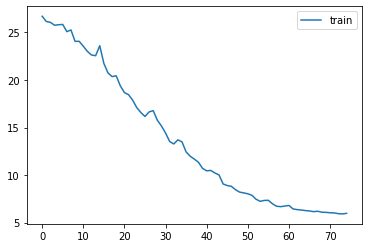

In [24]:
plt.plot(training_losses, label='train')
plt.legend()
plt.show()

#### Train MAP@12

In [25]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 47/47.0 [00:16<00:00,  2.90it/s]


In [26]:
predictions = torch.concat(predictions)

In [27]:
predictions.shape

torch.Size([47128, 12])

In [28]:
actuals = pd.read_csv('data/final_train_set_for_submission.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

47128

In [29]:
mapk(actuals, predictions.tolist(), 12)

0.9762013603929862

### Submission

In [30]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs_for_submission.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

47.0

In [31]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 47/47.0 [00:14<00:00,  3.33it/s]


In [32]:
predictions = torch.concat(predictions)

In [33]:
predictions.shape

torch.Size([47128, 12])

In [34]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [35]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [36]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0827487003',
 '0877332001',
 '0900043001',
 '0902229004',
 '0884550002',
 '0907954004',
 '0888028001',
 '0895361002',
 '0712216001',
 '0865073001',
 '0915526001',
 '0880059003']

In [37]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0827487003 0877332001 0900043001 0902229004 0884550002 0907954004 0888028001 0895361002 0712216001 0865073001 0915526001 0880059003'

In [38]:
submission_set_filt = pd.read_csv('data/final_submission_inputs_for_submission.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(47128, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
1,1,"11824,2456,28519,11826,3269,23088,11825,15029,...",0,0.0,0.0,0.29
2,2,"39073,40201,39074,1243,39277,40370,38239,40344...",0,0.0,0.0,0.23
3,3,"39975,18345,38864,35941,38864,35941,32663,3266...",0,1.0,1.0,0.42
4,4,"703,183,2689,4352,1011,38951,37019,37511,4332,546",0,1.0,1.0,0.25


In [39]:
len(predictions_strings)

47128

In [40]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [41]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [42]:
submission_set_filt['prediction_model'] = predictions_strings

In [43]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [44]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0827487003 0877332001 0900043001 0902229004 08...
1,1,"11824,2456,28519,11826,3269,23088,11825,15029,...",0,0.0,0.0,0.29,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0757926001 0640021019 0856440002 0788575004 08...
2,2,"39073,40201,39074,1243,39277,40370,38239,40344...",0,0.0,0.0,0.23,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0935892001 0902265001 0882900001 0878190003 09...
3,3,"39975,18345,38864,35941,38864,35941,32663,3266...",0,1.0,1.0,0.42,000fb6e772c5d0023892065e659963da90b1866035558e...,0870328003 0786022008 0919273004 0913272003 09...
4,4,"703,183,2689,4352,1011,38951,37019,37511,4332,546",0,1.0,1.0,0.25,0010e8eb18f131e724d6997909af0808adbba057529edb...,0720125007 0791587015 0610776002 0912204001 07...


In [45]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [47]:
sample_submission.isnull().sum() / sample_submission.shape[0]

customer_id         0.00000
prediction          0.00000
prediction_model    0.96565
dtype: float64

In [48]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [49]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [50]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0751471001 0706016001 0372860002 0610776002 04...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [51]:
sample_submission.to_csv('data/20220503-fashionrecv3_F.csv', index=False)

- Scored 0.0112 on the public leaderboard! Highest score by some margin!
- Still room for improvement with top scores around 0.03
- We achieved this score using model predictions for ~3.5% of total customers in the submission set
- Actual customers who made a transaction in a given week, as a % of total customers, is known to be ~10%
- Hence next steps would be to understand how to cater for these customers
  - How many of these additional customers are new customers?